# Preprocessing

### import images

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import pickle
import random

In [2]:
def plot_double(_img1, _img2, cmap='viridis'):
    plt.figure(figsize=(10,20))
    plt.subplot(121)
    plt.imshow(_img1, cmap=cmap)
    plt.subplot(122)
    plt.imshow(_img2, cmap=cmap)
    plt.yticks([])
    plt.subplots_adjust(wspace=0)

In [31]:
HARRIS_BLOCK_SIZE = 7
HARRIS_THRESHOLD = 0.001
LOWE_RATIO = 0.5
RANSAC_THRESHOLD = 0.5
RANSAC_SAMPLE = 4
RANSAC_STEPS = 1500

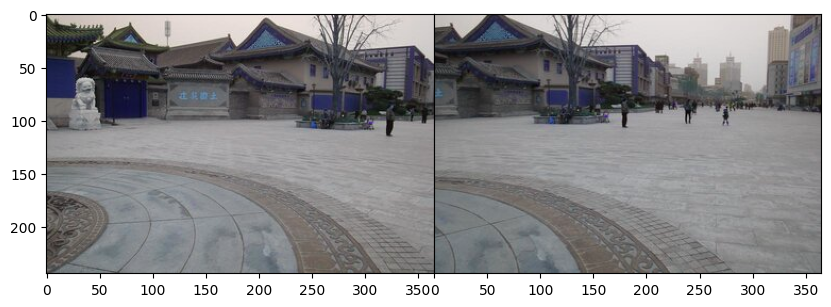

In [4]:
im1 = cv.imread('img/4_r.jpg')
im2 = cv.imread('img/5_r.jpg')
total_img = np.concatenate((im1, im2), axis=1)

imc1 = im1.copy()
imc2 = im2.copy()
plot_double(im1, im2)

In [5]:
im1.shape

(244, 365, 3)

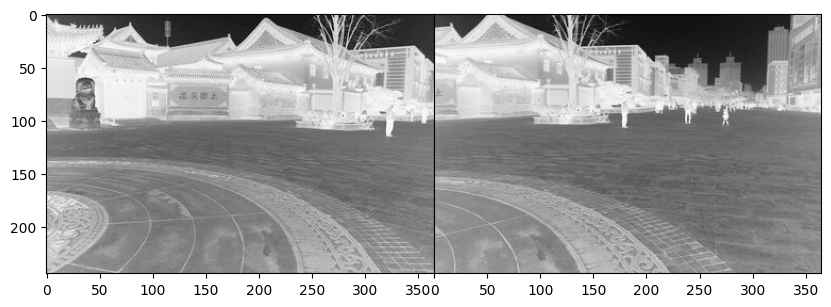

In [6]:
gray1 = cv.cvtColor(im1, cv.COLOR_BGR2GRAY)
gray2 = cv.cvtColor(im2, cv.COLOR_BGR2GRAY)
plot_double(gray1, gray2, 'Greys')

### extract harris corners

In [7]:
dst1 = cv.cornerHarris(gray1, HARRIS_BLOCK_SIZE, 3, 0.04)
dst2 = cv.cornerHarris(gray2, HARRIS_BLOCK_SIZE, 3, 0.04)
dst1.shape

(244, 365)

In [8]:
rows, cols = np.where(dst1 > HARRIS_THRESHOLD*dst1.max())
kps1 = np.array([rows, cols])

rows, cols = np.where(dst2 > HARRIS_THRESHOLD*dst2.max())
kps2 = np.array([rows, cols])

print(kps1.shape)
print(kps2.shape)

(2, 17415)
(2, 19185)


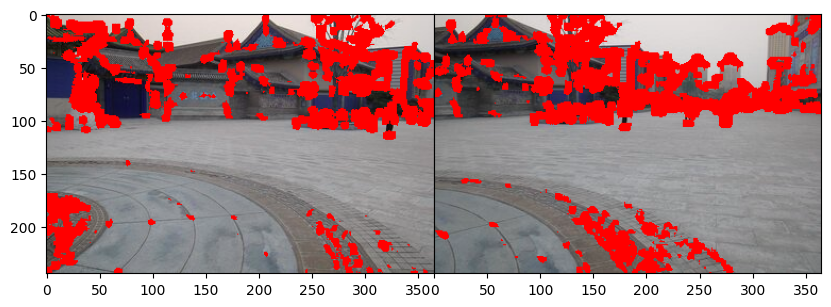

In [9]:
im1h = im1.copy()
im1h[kps1[0], kps1[1]]=[255,0,0]

im2h = im2.copy()
im2h[kps2[0], kps2[1]]=[255,0,0]

plot_double(im1h, im2h)

### calculate sift descriptors

In [10]:
kps1t, kps2t = kps1.T, kps2.T

cv_points1 = [cv.KeyPoint(float(x[1]), float(x[0]), 1) for x in kps1t]
cv_points2 = [cv.KeyPoint(float(x[1]), float(x[0]), 1) for x in kps2t]

In [11]:
sift = cv.SIFT_create()
kp1, des1 = sift.compute(gray1, cv_points1)
kp2, des2 = sift.compute(gray2, cv_points2)
kp1 = np.array(kp1)
kp2 = np.array(kp2)

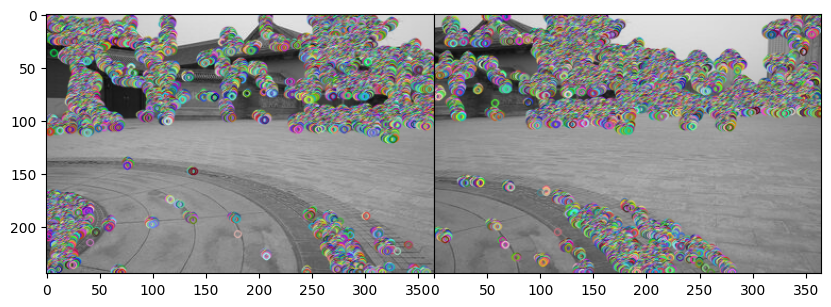

In [12]:
im3 = im1.copy()
im4 = im2.copy()
imkp1 = cv.drawKeypoints(gray1, kp1, im3)
imkp2 = cv.drawKeypoints(gray2, kp2, im4)

plot_double(imkp1, imkp2, 'Greys')

### calculate keypoint distances

In [13]:
print(des1.shape)
print(des2.shape)

(17415, 128)
(19185, 128)


In [14]:
dst_euclid = scipy.spatial.distance.cdist(des1, des2)

In [15]:
# dst_correlation = np.corrcoef(des1, des2)[:len(des1),len(des2):]
# dst_correlation = 1 - dst_correlation
# dst_correlation.shape

In [16]:
# dst_correlation = None

In [17]:
# db = {'dst_correlation': dst_correlation, 'dst_euclid': dst_euclid}
# with open('dst.pkl', 'wb') as f:
#     pickle.dump(db, f)

In [18]:
# with open('dst.pkl', 'rb') as f:
#     db = pickle.load(f)
# dst_correlation = db.correlation
# dst_euclid = db.dst_euclid

### find matching keypoints

In [19]:
dst = dst_euclid
matched_pairs = []
row_mx = []
for i in range(dst.shape[0]):
    p = np.partition(dst[i], 1)
    row_mx.append(p[:2])
row_mx = np.array(row_mx)
row_mx.shape

(17415, 2)

In [20]:
neighbor_threshold = LOWE_RATIO
for i in tqdm(range(dst.shape[0])):
    j = np.argmin(dst[i])
    if dst[i, j] == row_mx[i][0] and dst[i, j] < neighbor_threshold * row_mx[i][1]:
        matched_pairs.append((i, j))

100%|█████████████████████████████████████████████████████████████████████████| 17415/17415 [00:00<00:00, 55884.05it/s]


In [21]:
matched_pairs = np.array(matched_pairs)
matched_pairs.shape

(596, 2)

In [55]:
with open('mp.pkl', 'wb') as f:
    pickle.dump(matched_pairs, f)

In [105]:
# with open('mp.pkl', 'rb') as f:
#     matched_pairs = pickle.load(f)

In [22]:
matches = []
for id0, id1 in matched_pairs:
    arr = [kp1[id0].pt[0], kp1[id0].pt[1], kp2[id1].pt[0], kp2[id1].pt[1]]
    matches.append(arr)
matches = np.array(matches)

In [23]:
def plot_matches(matches, total_img):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(total_img.astype('uint8'))

    offset = total_img.shape[1] / 2
    for match in matches:
        x1, y1, x2, y2 = match
        ax.plot([x1, x2 + offset], [y1, y2], 'rx')
        ax.plot([x1, x2 + offset], [y1, y2], 'r', linewidth=0.5)

    plt.show()

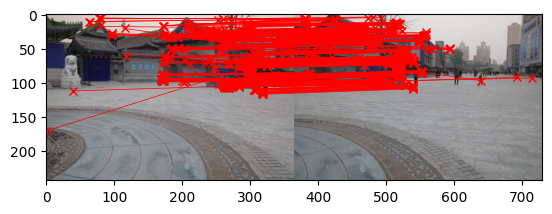

In [24]:
plot_matches(np.array(matches), total_img)

# Least Squares

In [25]:
def lstsq_solve(points):
    num_points = points.shape[0]
    A = np.zeros((2 * num_points, 8))
    b = np.zeros((2 * num_points, 1))

    for i in range(num_points):
        p1 = np.append(points[i][0:2], 1)
        p2 = np.append(points[i][2:4], 1)

        A[2 * i] = [-p1[0], -p1[1], -1, 0, 0, 0, p2[0]*p1[0], p2[0]*p1[1]]
        A[2 * i + 1] = [0, 0, 0, -p1[0], -p1[1], -1, p2[1]*p1[0], p2[1]*p1[1]]

        b[2 * i] = -p2[0]
        b[2 * i + 1] = -p2[1]

    x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    H = np.append(x, 1)
    H = H.reshape(3, 3)

    return H

In [26]:
transform = lstsq_solve(matches)

# Image Stitching

In [27]:
def stitch(left, right, M):

    translation_mat = np.array([[1, 0, 400.], [0, 1, 400.], [0, 0, 1]])

    new_height = 1000
    new_width = 1000

    translation_mat = np.eye(translation_mat.shape[0])
    translation_mat = np.array([[1, 0, 400.], [0, 1, 400.], [0, 0, 1]])
    M = np.dot(translation_mat, M)

    warped_l = cv.warpPerspective(src=left, M=M, dsize=(new_width, new_height))
    warped_r = cv.warpPerspective(src=right, M=translation_mat, dsize=(new_width, new_height))

    empty=(0,0,0)

    for i in tqdm(range(warped_r.shape[0])):
        for j in range(warped_r.shape[1]):
            pixel_l = warped_l[i, j, :]
            pixel_r = warped_r[i, j, :]

            if (pixel_l==empty).all():
                warped_l[i,j] = pixel_r
            elif (pixel_r==empty).all():
                warped_l[i,j] = pixel_l
            else:
                warped_l[i,j] = pixel_l * 0.5 + pixel_r * 0.5

    while (warped_l[:,0]==empty).all():
        warped_l = np.delete(warped_l,0,1)
    while (warped_l[:,-1]==empty).all():
        warped_l = np.delete(warped_l,-1,1)

    while (warped_l[0]==empty).all():
        warped_l = np.delete(warped_l,0,0)
    while (warped_l[-1]==empty).all():
        warped_l = np.delete(warped_l,-1,0)

    return warped_l

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.32it/s]


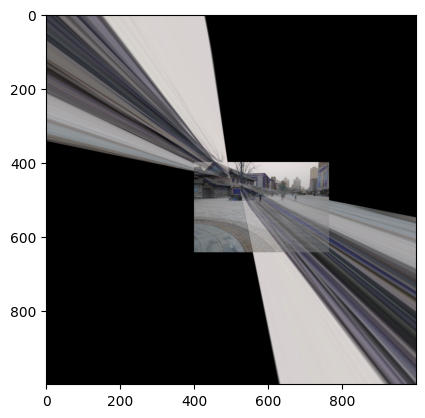

In [28]:
lstsq_result = stitch(im1, im2, transform)
plt.imshow(lstsq_result)

# RANSAC

In [29]:
def calc_error(points, H):
    num_points = len(points)
    all_p1 = np.column_stack((points[:, :2], np.ones((num_points, 1))))
    all_p2 = points[:, 2:4]

    estimate_p2_homogeneous = np.dot(H, all_p1.T).T
    estimate_p2 = (estimate_p2_homogeneous / estimate_p2_homogeneous[:, 2][:, None])[:, :2]

    errors = np.linalg.norm(all_p2 - estimate_p2, axis=1) ** 2

    return errors

In [30]:
def ransac(matches, threshold, sample_size, steps):
    inliers = []

    for i in range(steps):
        np.random.shuffle(matches)
        points = matches[:sample_size]
        cur_H = lstsq_solve(points)

        errors = calc_error(matches, cur_H)
        idx = np.where(errors < threshold)
        cur_inliers = matches[idx]

        if len(cur_inliers) > len(inliers):
            inliers = cur_inliers.copy()
            H = cur_H.copy()

    #print('%d/%d inliers ratio' % (len(inliers), len(matches)))
    return inliers, H

In [32]:
inliers, transform = ransac(matches, RANSAC_THRESHOLD, RANSAC_SAMPLE, RANSAC_STEPS)

In [33]:
print('%d/%d inliers ratio' % (len(inliers), len(matches)))

384/596 inliers ratio


In [34]:
score = sum(calc_error(inliers, transform).astype('float32'))
print('%f' % score)

60.429971


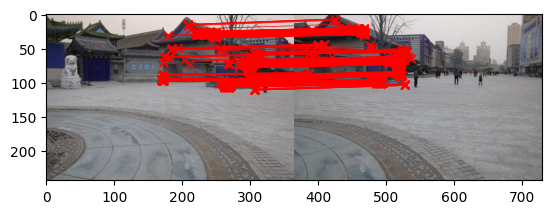

In [35]:
plot_matches(inliers, total_img)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 179.43it/s]


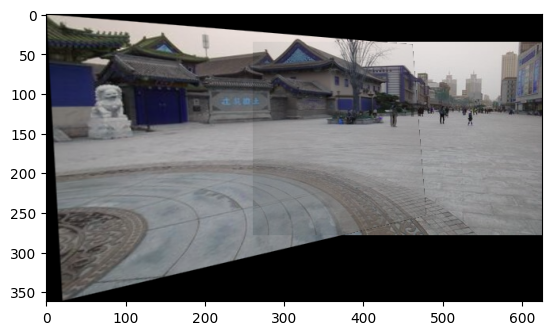

In [36]:
final_result = stitch(im1, im2, transform)
plt.imshow(final_result)

# Experiments

## the pipeline

In [48]:
S_LOWE_RANGE = [0.5, 0.7]
S_THRESH_RANGE = [0.3, 0.5]
S_SAMPLE_RANGE = [4, 5]
S_HARRIS_BRANGE = [7, 5, 2]
S_HARRIS_TRANGE = [0.003, 0.001]
S_RANSAC_STEPS = 2000

In [49]:
def preprocess(im_path1='img/4_r.jpg', im_path2='img/5_r.jpg'):
    im1 = cv.imread(im_path1)
    im2 = cv.imread(im_path2)
    total_img = np.concatenate((im1, im2), axis=1)

    gray1 = cv.cvtColor(im1, cv.COLOR_BGR2GRAY)
    gray2 = cv.cvtColor(im2, cv.COLOR_BGR2GRAY)

    return im1, gray1, im2, gray2

def get_matches(im1, gray1, im2, gray2, harris_block_size, harris_thresh, dst_file=None, save_dst=False):
    
    dst1 = cv.cornerHarris(gray1, harris_block_size, 3, 0.04)
    dst2 = cv.cornerHarris(gray2, harris_block_size, 3, 0.04)

    rows, cols = np.where(dst1 > harris_thresh*dst1.max())
    kps1 = np.array([rows, cols])
    
    rows, cols = np.where(dst2 > harris_thresh*dst2.max())
    kps2 = np.array([rows, cols])

    kps1t, kps2t = kps1.T, kps2.T

    cv_points1 = [cv.KeyPoint(float(x[1]), float(x[0]), 1) for x in kps1t]
    cv_points2 = [cv.KeyPoint(float(x[1]), float(x[0]), 1) for x in kps2t]

    sift = cv.SIFT_create()
    kp1, des1 = sift.compute(gray1, cv_points1)
    kp2, des2 = sift.compute(gray2, cv_points2)
    kp1 = np.array(kp1)
    kp2 = np.array(kp2)

    if dst_file != None:
        with open(dst_file, 'rb') as f:
            dst_euclid = pickle.load(f)
            print('loaded dst of shape {}'.format(dst_euclid.shape))
            return dst_euclid, kp1, kp2
    
    print('calculating euclid distances...')
    dst_euclid = scipy.spatial.distance.cdist(des1, des2)
    print('done')
    
    if save_dst:
        with open('new_dst.pkl', 'wb') as f:
            pickle.dump(dst_euclid, f)
    
    return dst_euclid, kp1, kp2

def solve(im1, gray1, im2, gray2, harris_block_size=7, harris_thresh=0.001, 
          lowe_range=S_LOWE_RANGE, thresh_range=S_THRESH_RANGE, sample_range=S_SAMPLE_RANGE):
    
    dst, kp1, kp2 = get_matches(im1, gray1, im2, gray2, harris_block_size, harris_thresh)#, save_dst=True)
    #dst, kp1, kp2 = get_matches(im1, gray1, im2, gray2, harris_block_size, harris_thresh, dst_file='new_dst.pkl')
    
    row_mx = []
    for i in range(dst.shape[0]):
        p = np.partition(dst[i], 1)
        row_mx.append(p[:2])
    row_mx = np.array(row_mx)

    ans = []
    for lowe in lowe_range:
        
        print('lowe %f' % lowe)
        print('filtering matches based on distance...')

        mprs = []
        for i in tqdm(range(dst.shape[0])):
            j = np.argmin(dst[i])
            if dst[i, j] == row_mx[i][0] and dst[i, j] < lowe * row_mx[i][1]:
                mprs.append([i, j])
        mprs = np.array(mprs)
    
        matches = []
        for id0, id1 in mprs:
            arr = [kp1[id0].pt[0], kp1[id0].pt[1], kp2[id1].pt[0], kp2[id1].pt[1]]
            matches.append(arr)
        matches = np.array(matches)
        print('done')

        print('ransac sensitivity analysis...')
        ransac_steps=S_RANSAC_STEPS
        for ransac_thresh in thresh_range:
            for ransac_sample_size in sample_range:
                print('ransac_thresh {} sample_size {}'.format(ransac_thresh, ransac_sample_size))
                print('running ransac...')
                print('num_matches ' + str(len(matches)))
    
                inliers_stack = []
                transform_stack = []
                score_stack = []
                
                for itr in range(5):
                    inliers, transform = ransac(matches, ransac_thresh, ransac_sample_size, ransac_steps)
                    inliers_stack.append(inliers)
                    transform_stack.append(transform)
                    fin_error = calc_error(inliers, transform).astype('float32')
                    score = sum([x**2 for x in fin_error])
                    ratio = len(inliers)/len(matches)
                    score_stack.append([score, ratio])
                score_stack = np.array(score_stack)
                max_score = np.max(score_stack[:,0])
                max_ratio = np.max(score_stack[:,1])

                metric_stack = []
                for i in range(len(score_stack)):
                    metric = score_stack[i][0]/max_score + score_stack[i][1]/max_ratio
                    metric_stack.append(metric)
                metric_stack = np.array(metric_stack)
                    
                best_candidate = np.argmin(metric_stack)
                inliers = inliers_stack[best_candidate]
                transform = transform_stack[best_candidate]
                
                print('done')
    
                print('stitching the images...')
                stitched_image = stitch(im1, im2, transform)
                print('done')
                out_filename = 'out/hbs{}_ht{}_l{}_rt{}_rss{}.jpg'.format(
                    harris_block_size, harris_thresh, lowe, ransac_thresh, ransac_sample_size)
                cv.imwrite(out_filename,  stitched_image)
    
                fin_error = calc_error(inliers, transform).astype('float32')
                score = sum([x**2 for x in fin_error])
                ans.append({'image': out_filename, 'outlier_ratio': len(inliers)/len(matches), 'score': score})
    return ans

### testing and ransac hyperparameter search

In [39]:
del dst, dst_euclid

In [50]:
im1, gray1, im2, gray2 = preprocess()
ans = []
res = solve(im1, gray1, im2, gray2)
ans.extend(res)
ans

calculating euclid distances...
done
lowe 0.500000
filtering matches based on distance...


100%|█████████████████████████████████████████████████████████████████████████| 17415/17415 [00:00<00:00, 47707.37it/s]


done
ransac sensitivity analysis...
ransac_thresh 0.3 sample_size 4
running ransac...
num_matches 596
done
stitching the images...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 188.93it/s]


done
ransac_thresh 0.3 sample_size 5
running ransac...
num_matches 596
done
stitching the images...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 213.25it/s]


done
ransac_thresh 0.5 sample_size 4
running ransac...
num_matches 596
done
stitching the images...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 208.43it/s]


done
ransac_thresh 0.5 sample_size 5
running ransac...
num_matches 596
done
stitching the images...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 200.90it/s]


done
lowe 0.700000
filtering matches based on distance...


100%|█████████████████████████████████████████████████████████████████████████| 17415/17415 [00:00<00:00, 48754.37it/s]


done
ransac sensitivity analysis...
ransac_thresh 0.3 sample_size 4
running ransac...
num_matches 2294
done
stitching the images...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 190.57it/s]


done
ransac_thresh 0.3 sample_size 5
running ransac...
num_matches 2294
done
stitching the images...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 178.66it/s]


done
ransac_thresh 0.5 sample_size 4
running ransac...
num_matches 2294
done
stitching the images...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.07it/s]


done
ransac_thresh 0.5 sample_size 5
running ransac...
num_matches 2294
done
stitching the images...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 176.92it/s]


done


[{'image': 'out/hbs7_ht0.001_l0.5_rt0.3_rss4.jpg',
  'outlier_ratio': 0.5318791946308725,
  'score': 4.590589382015847},
 {'image': 'out/hbs7_ht0.001_l0.5_rt0.3_rss5.jpg',
  'outlier_ratio': 0.535234899328859,
  'score': 5.421395478050902},
 {'image': 'out/hbs7_ht0.001_l0.5_rt0.5_rss4.jpg',
  'outlier_ratio': 0.6325503355704698,
  'score': 15.169757472056727},
 {'image': 'out/hbs7_ht0.001_l0.5_rt0.5_rss5.jpg',
  'outlier_ratio': 0.6409395973154363,
  'score': 17.835497755944882},
 {'image': 'out/hbs7_ht0.001_l0.7_rt0.3_rss4.jpg',
  'outlier_ratio': 0.3073234524847428,
  'score': 13.977303922699527},
 {'image': 'out/hbs7_ht0.001_l0.7_rt0.3_rss5.jpg',
  'outlier_ratio': 0.31386224934612034,
  'score': 15.866649919935805},
 {'image': 'out/hbs7_ht0.001_l0.7_rt0.5_rss4.jpg',
  'outlier_ratio': 0.4049694856146469,
  'score': 52.73796893413142},
 {'image': 'out/hbs7_ht0.001_l0.7_rt0.5_rss5.jpg',
  'outlier_ratio': 0.43199651264167394,
  'score': 56.05786301309618}]

In [46]:
pick_score = [[x['score'], x['image']] for x in ans]
pick_ratio = [[x['outlier_ratio'], x['image']] for x in ans]

pick_score = sorted(pick_score)
pick_ratio = sorted(pick_ratio)

print('by score')
for x in pick_score[:5]:
    print(x)
print('by ratio')
for x in pick_ratio[:5]:
    print(x)

max_score = pick_score[-1][0]
max_ratio = pick_ratio[-1][0]

metric = []
for i in range(len(pick_score)):
    pick_score[i][0] = pick_score[i][0]/max_score
    pick_ratio[i][0] = pick_ratio[i][0]/max_ratio
    metric.append([pick_score[i][0]+pick_ratio[i][0], pick_score[i][1]])
metric = sorted(metric)

print('by combined normalized minimization metric')
for x in metric[:5]:
    print(x)

by score
[1.802790469606407, 'out/hbs7_ht0.001_l0.3_rt0.3_rss5.jpg']
[1.8128700703382492, 'out/hbs7_ht0.001_l0.3_rt0.5_rss7.jpg']
[1.8383745811879635, 'out/hbs7_ht0.001_l0.3_rt0.3_rss4.jpg']
[1.855899328715168, 'out/hbs7_ht0.001_l0.3_rt0.3_rss7.jpg']
[1.9350486677139997, 'out/hbs7_ht0.001_l0.3_rt0.5_rss5.jpg']
by ratio
[0.2925021795989538, 'out/hbs7_ht0.001_l0.7_rt0.3_rss4.jpg']
[0.3282476024411508, 'out/hbs7_ht0.001_l0.7_rt0.3_rss5.jpg']
[0.33478639930252835, 'out/hbs7_ht0.001_l0.7_rt0.3_rss7.jpg']
[0.41368788142981694, 'out/hbs7_ht0.001_l0.7_rt0.5_rss5.jpg']
[0.4232781168265039, 'out/hbs7_ht0.001_l0.7_rt0.5_rss4.jpg']
by combined normalized minimization metric
[0.32396201534038555, 'out/hbs7_ht0.001_l0.3_rt0.3_rss5.jpg']
[0.36280704881494436, 'out/hbs7_ht0.001_l0.3_rt0.5_rss7.jpg']
[0.3699966896701348, 'out/hbs7_ht0.001_l0.3_rt0.3_rss4.jpg']
[0.455723255236787, 'out/hbs7_ht0.001_l0.3_rt0.3_rss7.jpg']
[0.4664159779119661, 'out/hbs7_ht0.001_l0.3_rt0.5_rss5.jpg']


### harris hyperparameter search

In [53]:
im1, gray1, im2, gray2 = preprocess()
harris_sens_ans = []
for harris_block_size in S_HARRIS_BRANGE:
    res = solve(im1, gray1, im2, gray2, harris_block_size, 0.001, [0.5], [0.5], [5])
    harris_sens_ans.extend(res)

for harris_thresh in S_HARRIS_TRANGE:
    res = solve(im1, gray1, im2, gray2, 7, harris_thresh, [0.5], [0.5], [5])
    harris_sens_ans.extend(res)
len(harris_sens_ans)

calculating euclid distances...
done
lowe 0.500000
filtering matches based on distance...


100%|█████████████████████████████████████████████████████████████████████████| 17415/17415 [00:00<00:00, 67784.85it/s]


done
ransac sensitivity analysis...
ransac_thresh 0.5 sample_size 5
running ransac...
num_matches 596
done
stitching the images...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 199.07it/s]


done
calculating euclid distances...
done
lowe 0.500000
filtering matches based on distance...


100%|█████████████████████████████████████████████████████████████████████████| 12195/12195 [00:00<00:00, 85552.51it/s]

done
ransac sensitivity analysis...
ransac_thresh 0.5 sample_size 5
running ransac...
num_matches 472


done
stitching the images...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 196.83it/s]


done
calculating euclid distances...
done
lowe 0.500000
filtering matches based on distance...


100%|██████████████████████████████████████████████████████████████████████████| 3355/3355 [00:00<00:00, 119276.55it/s]

done
ransac sensitivity analysis...
ransac_thresh 0.5 sample_size 5
running ransac...
num_matches 153


done
stitching the images...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 191.46it/s]


done
calculating euclid distances...
done
lowe 0.500000
filtering matches based on distance...


100%|█████████████████████████████████████████████████████████████████████████| 10234/10234 [00:00<00:00, 82121.20it/s]

done
ransac sensitivity analysis...
ransac_thresh 0.5 sample_size 5
running ransac...
num_matches 441


done
stitching the images...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.47it/s]


done
calculating euclid distances...
done
lowe 0.500000
filtering matches based on distance...


100%|█████████████████████████████████████████████████████████████████████████| 17415/17415 [00:00<00:00, 61298.11it/s]


done
ransac sensitivity analysis...
ransac_thresh 0.5 sample_size 5
running ransac...
num_matches 596
done
stitching the images...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 170.32it/s]


done


5

In [55]:
pick_score = [[x['score'], x['image']] for x in harris_sens_ans]
pick_ratio = [[x['outlier_ratio'], x['image']] for x in harris_sens_ans]

pick_score = sorted(pick_score)
pick_ratio = sorted(pick_ratio)

print('by score')
for x in pick_score[:5]:
    print(x)
print('by ratio')
for x in pick_ratio[:5]:
    print(x)

max_score = pick_score[-1][0]
max_ratio = pick_ratio[-1][0]

metric = []
for i in range(len(pick_score)):
    pick_score[i][0] = pick_score[i][0]/max_score
    pick_ratio[i][0] = pick_ratio[i][0]/max_ratio
    metric.append([pick_score[i][0]+pick_ratio[i][0], pick_score[i][1]])
metric = sorted(metric)

print('by combined normalized minimization metric')
for x in metric[:5]:
    print(x)

by score
[4.407332479716239, 'out/hbs2_ht0.001_l0.5_rt0.5_rss5.jpg']
[10.419875899609842, 'out/hbs7_ht0.003_l0.5_rt0.5_rss5.jpg']
[11.594259253444546, 'out/hbs5_ht0.001_l0.5_rt0.5_rss5.jpg']
[14.295853897177427, 'out/hbs7_ht0.001_l0.5_rt0.5_rss5.jpg']
[17.234112122979887, 'out/hbs7_ht0.001_l0.5_rt0.5_rss5.jpg']
by ratio
[0.5751633986928104, 'out/hbs2_ht0.001_l0.5_rt0.5_rss5.jpg']
[0.5986394557823129, 'out/hbs7_ht0.003_l0.5_rt0.5_rss5.jpg']
[0.6426174496644296, 'out/hbs7_ht0.001_l0.5_rt0.5_rss5.jpg']
[0.6442953020134228, 'out/hbs7_ht0.001_l0.5_rt0.5_rss5.jpg']
[0.6483050847457628, 'out/hbs5_ht0.001_l0.5_rt0.5_rss5.jpg']
by combined normalized minimization metric
[1.1429132189021902, 'out/hbs2_ht0.001_l0.5_rt0.5_rss5.jpg']
[1.527999221258273, 'out/hbs7_ht0.003_l0.5_rt0.5_rss5.jpg']
[1.6639775147918912, 'out/hbs5_ht0.001_l0.5_rt0.5_rss5.jpg']
[1.8233241372038609, 'out/hbs7_ht0.001_l0.5_rt0.5_rss5.jpg']
[2.0, 'out/hbs7_ht0.001_l0.5_rt0.5_rss5.jpg']
